In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# 1. Preparação do Ambiente e Dados
os.makedirs('../models', exist_ok=True)
df = pd.read_csv('../data/processed/biometria_final_pos.csv')

# Selecionar apenas colunas de geometria (28 distâncias + ângulos + áreas)
cols_geo = [col for col in df.columns if col.startswith('geo_')]
X_geo = df[cols_geo]
le = LabelEncoder()
y = le.fit_transform(df['cow_id'])

# 2. Grid Search para encontrar os melhores parâmetros (Otimização)
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

print("🔍 Iniciando Grid Search com Geometria...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_search = XGBClassifier(tree_method='hist', device='cuda', random_state=42)

grid = GridSearchCV(xgb_search, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_geo, y)

best_params = grid.best_params_
print(f"🏆 Melhores Parâmetros: {best_params}")

# 3. Cross-Validation (Validação Robusta)
best_xgb_geo = grid.best_estimator_
cv_geo = cross_val_score(best_xgb_geo, X_geo, y, cv=skf)

print(f"✅ Acurácia Média (Geometria Pura): {cv_geo.mean():.2%} (+/- {cv_geo.std() * 2:.2%})")

🔍 Iniciando Grid Search com Geometria...


/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [15:31:16] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [15:31:18] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structu

🏆 Melhores Parâmetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}


/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [15:55:17] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


✅ Acurácia Média (Geometria Pura): 24.73% (+/- 2.71%)


In [2]:
# 1. Selecionar Geometria + Estatísticas de Cor
cols_cor = [col for col in df.columns if 'mean' in col or 'std' in col]
X_hybrid = df[cols_geo + cols_cor]

# 2. Cross-Validation com os parâmetros do Grid anterior
xgb_hybrid = XGBClassifier(**best_params, tree_method='hist', device='cuda', random_state=42)

print(f"📊 Avaliando Híbrido (Geometria + Cor)...")
cv_hybrid = cross_val_score(xgb_hybrid, X_hybrid, y, cv=skf)

print(f"✅ Acurácia Média (Híbrido): {cv_hybrid.mean():.2%} (+/- {cv_hybrid.std() * 2:.2%})")

📊 Avaliando Híbrido (Geometria + Cor)...
✅ Acurácia Média (Híbrido): 55.87% (+/- 3.23%)


🚀 Avaliando Modelo Completo (Incluindo SIFT Binarizado)...
✅ Acurácia Média (Modelo Final): 55.93% (+/- 2.08%)


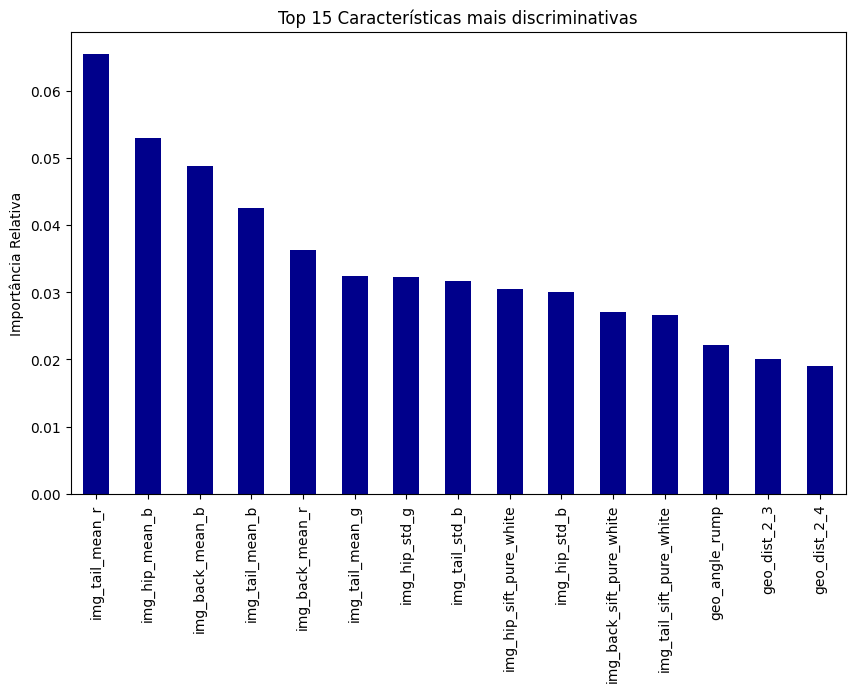

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Selecionar Todas as Features
cols_all = [col for col in df.columns if col.startswith(('geo_', 'img_'))]
X_full = df[cols_all]

# 2. Cross-Validation Final
xgb_full = XGBClassifier(**best_params, tree_method='hist', device='cuda', random_state=42)

print(f"🚀 Avaliando Modelo Completo (Incluindo SIFT Binarizado)...")
cv_full = cross_val_score(xgb_full, X_full, y, cv=skf)

print(f"✅ Acurácia Média (Modelo Final): {cv_full.mean():.2%} (+/- {cv_full.std() * 2:.2%})")

# 3. Análise de Importância para o relatório
xgb_full.fit(X_full, y)
importancias = pd.Series(xgb_full.feature_importances_, index=cols_all).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importancias.head(15).plot(kind='bar', color='darkblue')
plt.title('Top 15 Características mais discriminativas')
plt.ylabel('Importância Relativa')
plt.show()

In [6]:
# --- Célula 3 Otimizada (Rigor de Pós-Graduação) ---
print("🔍 Refazendo Grid Search para o Modelo Completo (Geo + Cor + SIFT)...")

# 1. Definir todas as features
cols_all = [col for col in df.columns if col.startswith(('geo_', 'img_'))]
X_full = df[cols_all]

# 2. Grid Search específico para o conjunto completo
grid_full = GridSearchCV(
    XGBClassifier(tree_method='hist', device='cuda', random_state=42),
    param_grid, # Usa o mesmo dicionário de parâmetros definido na Célula 1
    cv=skf, 
    scoring='accuracy', 
    n_jobs=-1
)
grid_full.fit(X_full, y)

print(f"🏆 Novos Melhores Parâmetros (Full): {grid_full.best_params_}")
print(f"📈 Acurácia Otimizada: {grid_full.best_score_:.2%}")

# 3. Validação Cruzada Final
cv_final = cross_val_score(grid_full.best_estimator_, X_full, y, cv=skf)
print(f"✅ Acurácia Média Final: {cv_final.mean():.2%} (+/- {cv_final.std() * 2:.2%})")

🔍 Refazendo Grid Search para o Modelo Completo (Geo + Cor + SIFT)...


/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [16:12:09] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [16:12:09] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structu

🏆 Novos Melhores Parâmetros (Full): {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
📈 Acurácia Otimizada: 57.07%
✅ Acurácia Média Final: 57.07% (+/- 4.96%)


In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Preparar Dados (Full Features)
cols_all = [col for col in df.columns if col.startswith(('geo_', 'img_'))]
X = df[cols_all]
y = le.transform(df['cow_id']) # Usando o LabelEncoder já definido

# 2. Criar Pipeline com Escalonamento (Obrigatório para SVM)
# O Pipeline garante que o escalonamento seja feito dentro de cada fold do CV
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# 3. Grid Search para SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01]
}

print("🔍 Iniciando Grid Search para SVM (RBF)...")
grid_svm = GridSearchCV(svm_pipe, param_grid_svm, cv=skf, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X, y)

print(f"🏆 Melhores Parâmetros SVM: {grid_svm.best_params_}")
print(f"✅ Acurácia Média SVM: {grid_svm.best_score_:.2%}")

🔍 Iniciando Grid Search para SVM (RBF)...
🏆 Melhores Parâmetros SVM: {'svm__C': 10, 'svm__gamma': 'scale'}
✅ Acurácia Média SVM: 61.67%


In [8]:
from sklearn.neural_network import MLPClassifier

# 1. Criar Pipeline para MLP
mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# 2. Grid Search para MLP
# Nota: hidden_layer_sizes (128,) é uma camada, (64, 64) são duas
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(128,), (64, 64), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.01]
}

print("🔍 Iniciando Grid Search para MLP (Rede Neural)...")
grid_mlp = GridSearchCV(mlp_pipe, param_grid_mlp, cv=skf, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X, y)

print(f"🏆 Melhores Parâmetros MLP: {grid_mlp.best_params_}")
print(f"✅ Acurácia Média MLP: {grid_mlp.best_score_:.2%}")

🔍 Iniciando Grid Search para MLP (Rede Neural)...
🏆 Melhores Parâmetros MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (128, 64)}
✅ Acurácia Média MLP: 59.53%


In [2]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# 1. Preparação
le = LabelEncoder()
y_encoded = le.fit_transform(df['cow_id'])

def objective(trial):
    # Definir espaço de busca
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }
    
    clf = XGBClassifier(**params)
    # Usamos cross-validation para garantir que o parâmetro é robusto
    score = cross_val_score(clf, X_scaled, y_encoded, cv=3, n_jobs=-1).mean()
    return score

# 2. Execução da Otimização
print("🔍 Iniciando Otimização Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) # 30 tentativas inteligentes

print(f"\n🏆 Melhor Acurácia Optuna: {study.best_value:.2%}")
print(f"📌 Melhores Parâmetros: {study.best_params}")

[I 2026-02-25 17:04:08,508] A new study created in memory with name: no-name-c55eddda-c017-4c4a-aff1-b257526a7abc


🔍 Iniciando Otimização Optuna...


/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [17:05:21] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [17:05:21] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structu


🏆 Melhor Acurácia Optuna: 55.80%
📌 Melhores Parâmetros: {'n_estimators': 656, 'max_depth': 14, 'learning_rate': 0.04843654177779972, 'subsample': 0.6625813035894326, 'colsample_bytree': 0.7664893638205674}
